<a href="https://colab.research.google.com/github/kakaandriano0-hash/natural-style/blob/main/Latihan%20VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

LATENT_DIM = 2
EPOCHS = 30
BATCH_SIZE = 128

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train_flat = x_train.reshape((-1, 784))
x_test_flat = x_test.reshape((-1, 784))

print(f"Training shape: {x_train_flat.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training shape: (60000, 784)


In [2]:
class Sampling(layers.Layer):
    """Menggunakan (z_mean, z_log_var) untuk men-sample z, vektor encoding."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
encoder_inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z_vae = Sampling()([z_mean, z_log_var])

z_ae = layers.Dense(LATENT_DIM, name="z_ae")(x)

encoder_vae = keras.Model(encoder_inputs, [z_mean, z_log_var, z_vae], name="encoder_vae")
encoder_ae = keras.Model(encoder_inputs, z_ae, name="encoder_ae")

latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = layers.Dense(784, activation="sigmoid")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

vae_outputs = decoder(encoder_vae(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

ae_outputs = decoder(encoder_ae(encoder_inputs))
ae = keras.Model(encoder_inputs, ae_outputs, name="ae")

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)

            reconstruction_loss = reconstruction_loss * 784

            reconstruction_loss = tf.reduce_mean(reconstruction_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


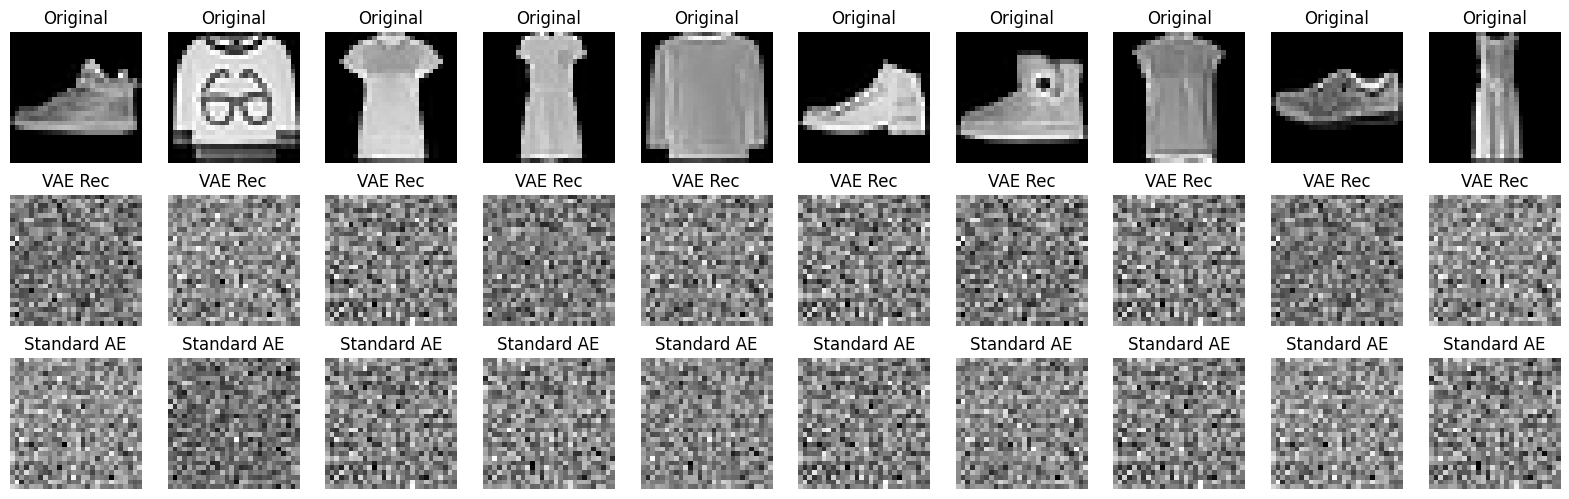

In [6]:
def plot_reconstruction(model_vae, model_ae, x_data, n=10):
    plt.figure(figsize=(20, 6))

    indices = np.random.randint(0, len(x_data), n)
    samples = x_data[indices]


    _, _, z_sample = model_vae.encoder.predict(samples)
    rec_vae = model_vae.decoder.predict(z_sample)

    rec_ae = model_ae.predict(samples)

    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(rec_vae[i].reshape(28, 28), cmap="gray")
        plt.title("VAE Rec")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(rec_ae[i].reshape(28, 28), cmap="gray")
        plt.title("Standard AE")
        plt.axis("off")

    plt.show()

plot_reconstruction(vae_model, ae, x_test_flat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


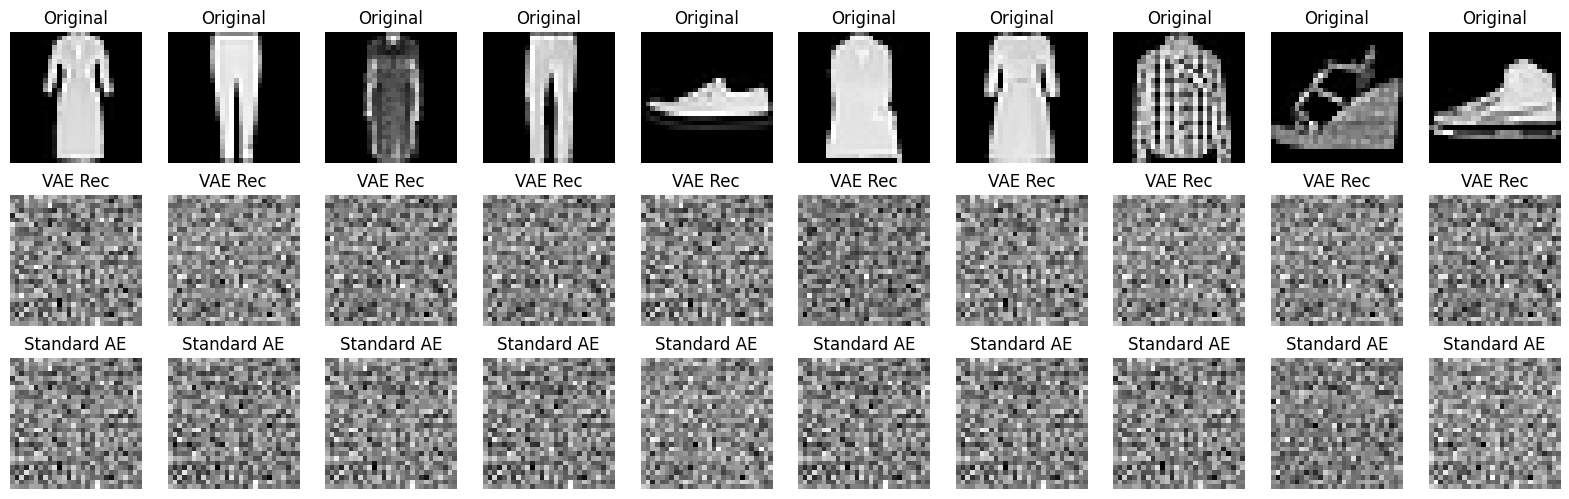

In [7]:
def plot_reconstruction(model_vae, model_ae, x_data, n=10):
    plt.figure(figsize=(20, 6))

    indices = np.random.randint(0, len(x_data), n)
    samples = x_data[indices]


    _, _, z_sample = model_vae.encoder.predict(samples)
    rec_vae = model_vae.decoder.predict(z_sample)

    rec_ae = model_ae.predict(samples)

    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(rec_vae[i].reshape(28, 28), cmap="gray")
        plt.title("VAE Rec")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(rec_ae[i].reshape(28, 28), cmap="gray")
        plt.title("Standard AE")
        plt.axis("off")

    plt.show()

plot_reconstruction(vae_model, ae, x_test_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


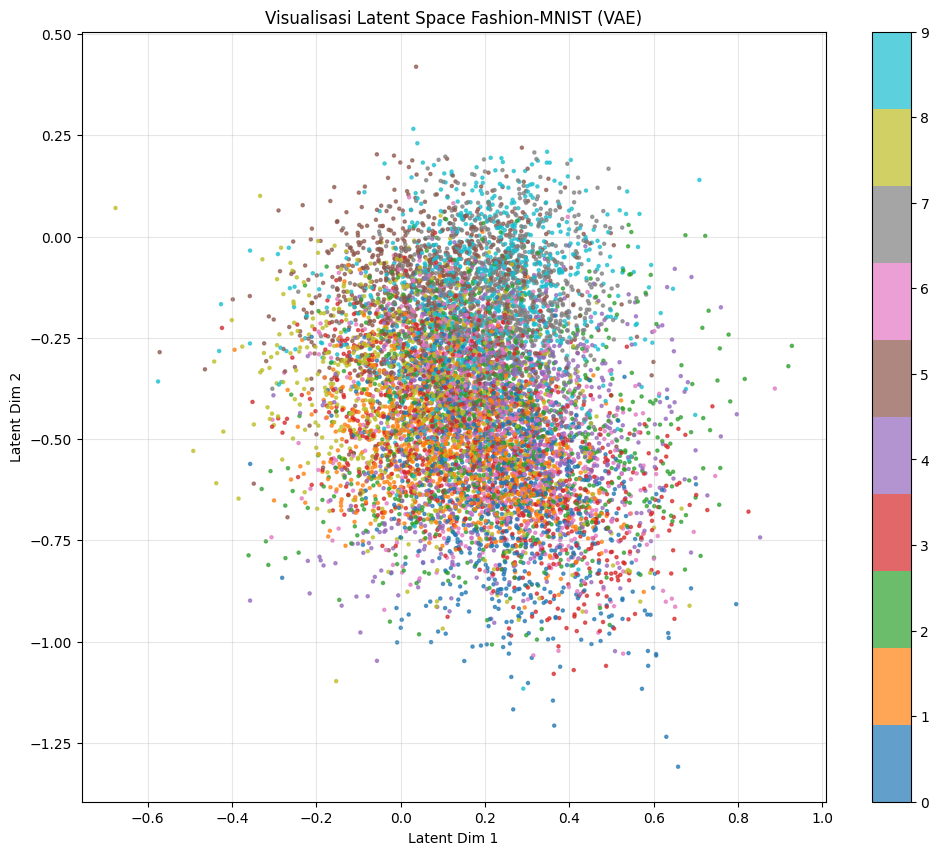

In [8]:
def plot_latent_space(encoder, x_data, y_data):
    z_mean, _, _ = encoder.predict(x_data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_data, cmap="tab10", s=5, alpha=0.7)
    plt.colorbar()
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.title("Visualisasi Latent Space Fashion-MNIST (VAE)")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_latent_space(encoder_vae, x_test_flat, y_test)

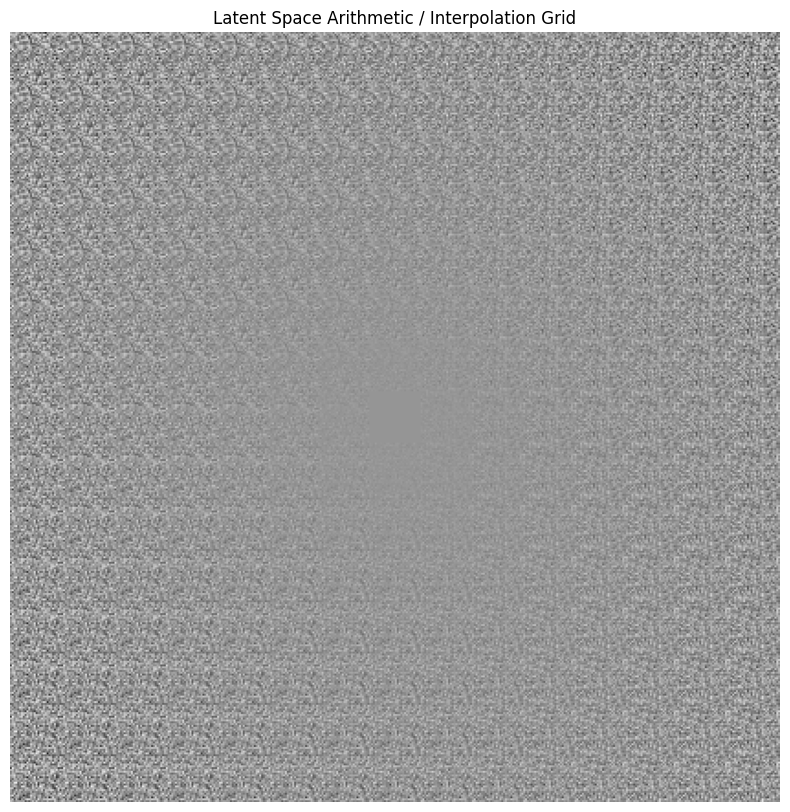

In [9]:
def plot_interpolation(decoder, n=15, scale=3.0):

    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)

            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="Greys_r")
    plt.title("Latent Space Arithmetic / Interpolation Grid")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.axis("off")
    plt.show()

plot_interpolation(decoder)